##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Variational Auto Encoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example we show how to fit a Variational Autoencoder using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [2]:
#@title Import { display-mode: "form" }


import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2022-02-09 20:19:48.217761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

### Load Dataset

In [4]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.AUTOTUNE))

Note that _preprocess() above returns `image, image` rather than just `image` because Keras is set up for discriminative models with an (example, label) input format, i.e. $p_\theta(y|x)$. Since the goal of the VAE is to recover the input x from x itself (i.e. $p_\theta(x|x)$), the data pair is (example, example).

### VAE Code Golf

#### Specify model.

In [5]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [6]:
input_shape

(28, 28, 1)

In [7]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [8]:
class Test_model(tf.keras.Model):
    def __init__(self):
        super(Test_model, self).__init__()
        self.prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
        self.encoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=input_shape),
            tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
            tfkl.Conv2D(base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(2 * base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(2 * base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                        padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Flatten(),
            tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
                       activation=None),
            tfpl.MultivariateNormalTriL(
                encoded_size,
                activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior)),
        ])
        
        self.decoder = tfk.Sequential([
            tfkl.InputLayer(input_shape=[encoded_size]),
            tfkl.Reshape([1, 1, encoded_size]),
            tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                                 padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                                 padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                        padding='same', activation=None),
            tfkl.Flatten(),
        ])
        self.decoder_out = tfpl.IndependentBernoulli(
                input_shape,
#                 tfd.Bernoulli.logits
            )
    def call(self,features):
        hidden_state = self.encoder(features)
#         print(hidden_state)
        output = self.decoder(hidden_state)
        output = self.decoder_out(output)
        return output

In [9]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))
vae = Test_model()

2022-02-09 20:19:49.077067: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Do inference.

In [10]:
def negloglik(x,rv_x):
    print(rv_x)
    return -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_dataset,
            epochs=10,
            validation_data=eval_dataset)

Epoch 1/10
tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[?], event_shape=[28, 28, 1], dtype=float32)
tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[?], event_shape=[28, 28, 1], dtype=float32)
 97/235 [===========>..................] - ETA: 2:13 - loss: 245.0556

### Look Ma, No ~~Hands~~Tensors!

In [ ]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[10], event_shape=[16], dtype=float32)


In [ ]:
#@title Image Plot Util
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()

Originals:


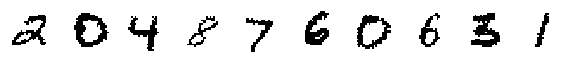

Decoded Random Samples:


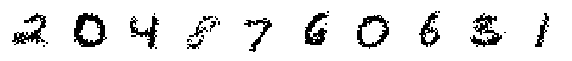

Decoded Modes:


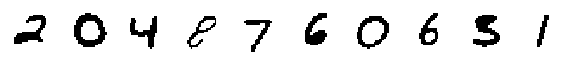

Decoded Means:


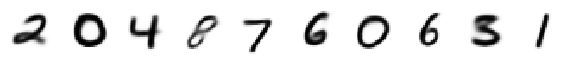

In [ ]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [ ]:
# Now, let's generate ten never-before-seen digits.
z = vae.prior.sample(10)
xtilde = vae.decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


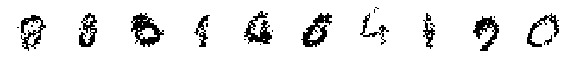

Randomly Generated Modes:


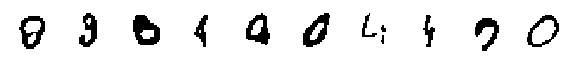

Randomly Generated Means:


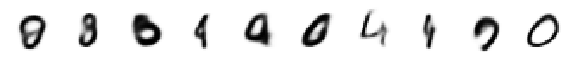

In [ ]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())